In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
from data_loader import load
from utils.data_pipeline import configure_for_performance

# Dataset load

In [3]:
root_dir = "/home/files/datasets/PF-dataset-PASCAL"
(train_ds, val_ds), class_names = load("PF_Pascal", root_dir, "classification")

In [4]:
class_names

['train',
 'person',
 'diningtable',
 'cat',
 'pottedplant',
 'bottle',
 'motorbike',
 'cow',
 'dog',
 'sheep',
 'tvmonitor',
 'horse',
 'aeroplane',
 'sofa',
 'chair',
 'boat',
 'bird',
 'bus',
 'bicycle',
 'car']

In [5]:
num_class = len(class_names)

# Data pipeline for high speed processing

In [6]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Explore images

(32, 224, 224, 3) (32,)


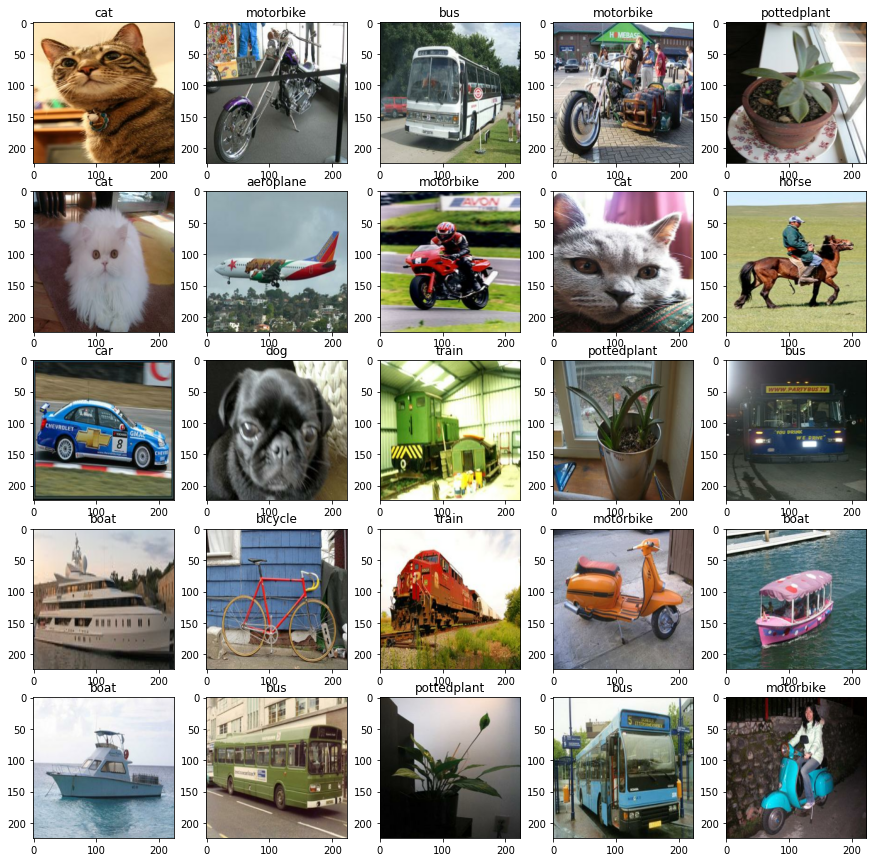

In [7]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)

fig = plt.figure(figsize=(15,15))
for i in range(5):
    for j in range(5):
        ax = fig.add_subplot(5,5,i*5+j+1)
        class_name = class_names[y[i*5+j]]
        ax.set_title(class_name)
        ax.imshow(x[i*5+j]/255.)
plt.show()

In [8]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Softmax

In [9]:
from models.BOF import block

In [14]:
input_layer = tf.keras.Input(shape=(224,224,3))
x = Conv2D(64, (3,3), strides=1, padding='same', activation='relu')(input_layer)
print("first conv output shape", x.shape)
x1 = block(64, (224, 224, 64))(x)
print("first block output shape", x1.shape)
x2 = block(128, (112, 112, 64))(x1)
print("second block output shape", x2.shape)
x3 = block(256, (56, 56, 128))(x2)
print("third block output shape", x3.shape)
x4 = block(512, (28, 28, 256))(x3)
print("fifth block output shape", x4.shape)
embedding = GlobalAveragePooling2D()(x4)
print("embedding(sum of heatmap)", embedding.shape)
scores = Dense(num_class)(embedding)
prob = Softmax()(scores)

BOF = tf.keras.Model(input_layer, prob)

first conv output shape (None, 224, 224, 64)
first block output shape (None, 112, 112, 64)
second block output shape (None, 56, 56, 128)
third block output shape (None, 28, 28, 256)
fifth block output shape (None, 14, 14, 512)
embedding(sum of heatmap) (None, 512)


In [11]:
BOF.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
functional_1 (Functional)    (None, 112, 112, 64)      82688     
_________________________________________________________________
functional_3 (Functional)    (None, 56, 56, 128)       312832    
_________________________________________________________________
functional_5 (Functional)    (None, 28, 28, 256)       1248256   
_________________________________________________________________
functional_7 (Functional)    (None, 14, 14, 512)       4986880   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)              

In [12]:
input_layer = tf.keras.Input(shape=(224,224,3))
x = Conv2D(64, (3,3), strides=1, padding='same', activation='relu')(input_layer)
print("first conv output shape", x.shape)
x1 = block(64, (224, 224, 64))(x)
print("first block output shape", x1.shape)
x2 = block(128, (112, 112, 64))(x1)
print("second block output shape", x2.shape)
x3 = block(256, (56, 56, 128))(x2)
print("third block output shape", x3.shape)
x4 = block(512, (28, 28, 256))(x3)
print("fifth block output shape", x4.shape)
heatmaps = Conv2D(num_class, (1,1), strides=1, activation=None)(x4)
scores = GlobalAveragePooling2D()(heatmaps)
prob = Softmax()(scores)

BOF_v2 = tf.keras.Model(input_layer, prob)

first conv output shape (None, 224, 224, 64)
first block output shape (None, 112, 112, 64)
second block output shape (None, 56, 56, 128)
third block output shape (None, 28, 28, 256)
fifth block output shape (None, 14, 14, 512)


In [13]:
BOF_v2.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
functional_11 (Functional)   (None, 112, 112, 64)      82688     
_________________________________________________________________
functional_13 (Functional)   (None, 56, 56, 128)       312832    
_________________________________________________________________
functional_15 (Functional)   (None, 28, 28, 256)       1248256   
_________________________________________________________________
functional_17 (Functional)   (None, 14, 14, 512)       4986880   
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 20)      

In [ ]:
# 원저자 구현 차이는 카테